In [21]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import neurokit as nk
import seaborn as sns
import pandas as pd
from scipy.interpolate import interp1d
from sklearn import preprocessing, datasets, ensemble, model_selection
from sklearn.ensemble import RandomForestClassifier

In [22]:
data_set_path = r"C:\Users\luiza\Documents\UFSC\TCC_Datasets\WESAD\WESAD"


In [23]:
# Lista para armazenar os dados combinados de todos os diretórios
all_data = []

# Lista de diretórios de S2 a S17
folders = [f"S{i}" for i in range(2, 18)]

for folder_name in folders:
    folder_path = os.path.join(data_set_path, folder_name)

    if os.path.exists(folder_path):
        for folder in os.listdir(folder_path):
            if folder.endswith(".pkl"):
                caminho_arquivo_pkl = os.path.join(folder_path, folder)
                
                # Abrir o arquivo .pkl
                with open(caminho_arquivo_pkl, 'rb') as infile:
                    obj = pickle.load(infile, encoding='latin1')
                    bvp=obj['signal']['wrist']['BVP'][:,0]
                    eda=obj['signal']['wrist']['EDA'][:,0]
                    temp=obj['signal']['wrist']['TEMP'][:,0]
                    label=obj['label']



In [24]:
fs_label = 700  # Hz
fs_temp_eda = 4  # Hz
fs_bvp = 64  # Hz

len_label = len(label)
len_temp_eda = len(temp)
len_bvp = len(bvp)

total_time = len_label / fs_label

time_label = np.linspace(0, total_time, len_label, endpoint=False)
time_temp_eda = np.linspace(0, total_time, len_temp_eda, endpoint=False)
time_bvp = np.linspace(0, total_time, len_bvp, endpoint=False)


interp_temp = interp1d(time_temp_eda, temp, kind='nearest', fill_value='extrapolate')
interp_eda = interp1d(time_temp_eda, eda, kind='nearest', fill_value='extrapolate')
interp_bvp = interp1d(time_bvp, bvp, kind='nearest', fill_value='extrapolate')

aligned_temp = interp_temp(time_label)
aligned_eda = interp_eda(time_label)
aligned_bvp = interp_bvp(time_label)

In [25]:
hr_data = []
folders = [f"S{i}" for i in range(2, 18)]


for folder_name in folders:
    subfolder_name = f"{folder_name}_E4_Data"
    folder_path = os.path.join(data_set_path, folder_name, subfolder_name)

    if os.path.exists(folder_path):
        csv_path = os.path.join(folder_path, 'HR.csv')
        if os.path.exists(csv_path):
            hr = pd.read_csv(csv_path, skiprows=2, usecols=[0], header=None)
            hr_data.append(hr)

if hr_data:
    combined_hr_df = pd.concat(hr_data, ignore_index=True)
    # Converte para numpy array
    hr = combined_hr_df.iloc[:, 0].to_numpy()

fs_hr = 1  # Hz
len_hr = len(hr)
time_hr = np.linspace(0, total_time, len_hr, endpoint=False)
interp_hr = interp1d(time_hr, hr, kind='nearest', fill_value='extrapolate')
aligned_hr = interp_hr(time_label)

In [26]:
numpy_data = np.column_stack((aligned_bvp, aligned_hr, aligned_eda, aligned_temp, label))
all_data.append(numpy_data)
combined_data = np.concatenate(all_data, axis=0)
column_names = ["bvp", "hr", "eda", "temp", "label"]
df = pd.DataFrame(data=combined_data, columns=column_names)

In [27]:
df

,bvp,hr,eda,temp,label
0,-0.49,101.00,2.015176,33.39,0.0
1,-0.49,101.00,2.015176,33.39,0.0
2,-0.49,101.00,2.015176,33.39,0.0
3,-0.49,101.00,2.015176,33.39,0.0
4,-0.49,101.00,2.015176,33.39,0.0
...,...,...,...,...,...
4143995,-6.21,73.65,0.783331,31.81,0.0
4143996,-6.21,73.65,0.783331,31.81,0.0
4143997,-6.21,73.65,0.783331,31.81,0.0
4143998,-6.21,73.65,0.783331,31.81,0.0


In [28]:
# 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset 
df = df[df['label'] != 7.0]
df= df[df['label'] != 6.0]
df= df[df['label'] != 5.0]
df = df.drop_duplicates()

In [29]:
df

,bvp,hr,eda,temp,label
0,-0.49,101.00,2.015176,33.39,0.0
6,-0.38,101.00,2.015176,33.39,0.0
17,-0.36,101.00,2.015176,33.39,0.0
20,-0.36,106.50,2.015176,33.39,0.0
28,-0.75,106.50,2.015176,33.39,0.0
...,...,...,...,...,...
4143942,-2.09,73.65,0.783331,31.81,0.0
4143951,-3.28,73.65,0.783331,31.81,0.0
4143962,-4.43,73.65,0.783331,31.81,0.0
4143973,-5.44,73.65,0.783331,31.81,0.0


In [30]:
X = df.drop(columns=["label"])  # Remove a coluna "label" para obter os recursos
y = df["label"] # 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset
y = y.astype(int)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## NORMALIZAR E CRIAR MIN, MEAN, MAX


Temperatura

In [31]:
temp_min = []
temp_max = []
temp_mean = []

for i in range(0, len(df), 3):
    temps = df['temp'].iloc[i:i+3]
    temp_min.append(temps.min())
    temp_max.append(temps.max())
    temp_mean.append(temps.mean())

temp_stats = pd.DataFrame({'temp_min': temp_min, 'temp_max': temp_max, 'temp_mean': temp_mean})

In [32]:
temp_min_array = np.array(temp_stats['temp_min'])
normalized_temp_min = preprocessing.normalize([temp_min_array])
temp_max_array = np.array(temp_stats['temp_max'])
normalized_temp_max = preprocessing.normalize([temp_max_array])
temp_mean_array = np.array(temp_stats['temp_mean'])
normalized_temp_mean = preprocessing.normalize([temp_mean_array])


In [33]:
data_temp = {
    'normalized_temp_mean': normalized_temp_mean.flatten(),
    'normalized_temp_max': normalized_temp_max.flatten(),
    'normalized_temp_min': normalized_temp_min.flatten()
}

df_temp = pd.DataFrame(data_temp)
df_temp.head()

,normalized_temp_mean,normalized_temp_max,normalized_temp_min
0,0.002561,0.002561,0.002561
1,0.002561,0.002561,0.002561
2,0.002561,0.002561,0.002561
3,0.002561,0.002561,0.002559
4,0.002559,0.002559,0.002559



EDA

In [34]:
eda_min = []
eda_max = []
eda_mean = []
for i in range(0, len(df), 3):
    eda = df['eda'].iloc[i:i+3]
    eda_min.append(eda.min())
    eda_max.append(eda.max())
    eda_mean.append(eda.mean())

eda_stats = pd.DataFrame({'eda_min': eda_min, 'eda_max': eda_max, 'eda_mean': eda_mean})

In [35]:
print(eda_stats.head())

    eda_min   eda_max  eda_mean
0  2.015176  2.015176  2.015176
1  2.015176  2.015176  2.015176
2  2.015176  2.015176  2.015176
3  2.012617  2.015176  2.014323
4  2.012617  2.012617  2.012617


In [36]:
eda_min_array = np.array(eda_stats['eda_min'])
normalized_eda_min = preprocessing.normalize([eda_min_array])
eda_max_array = np.array(eda_stats['eda_max'])
normalized_eda_max = preprocessing.normalize([eda_max_array])
eda_mean_array = np.array(eda_stats['eda_mean'])
normalized_eda_mean = preprocessing.normalize([eda_mean_array])


In [37]:
data_eda = {
    'normalized_eda_mean': normalized_eda_mean.flatten(),
    'normalized_eda_max': normalized_eda_max.flatten(),
    'normalized_eda_min': normalized_eda_min.flatten()
}

df_eda = pd.DataFrame(data_eda)
df_eda.head()

,normalized_eda_mean,normalized_eda_max,normalized_eda_min
0,0.004543,0.004542,0.004544
1,0.004543,0.004542,0.004544
2,0.004543,0.004542,0.004544
3,0.004541,0.004542,0.004539
4,0.004537,0.004536,0.004539


HR


In [38]:
hr_min = []
hr_max = []
hr_mean = []
for i in range(0, len(df), 3):
    hr = df['hr'].iloc[i:i+3]
    hr_min.append(hr.min())
    hr_max.append(hr.max())
    hr_mean.append(hr.mean())

hr_stats = pd.DataFrame({'hr_min': hr_min, 'hr_max': hr_max, 'hr_mean': hr_mean})

hr_min_array = np.array(hr_stats['hr_min'])
normalized_hr_min = preprocessing.normalize([hr_min_array])
hr_max_array = np.array(hr_stats['hr_max'])
normalized_hr_max = preprocessing.normalize([hr_max_array])
hr_mean_array = np.array(hr_stats['hr_mean'])
normalized_hr_mean = preprocessing.normalize([hr_mean_array])

In [39]:
data_hr = {
    'normalized_hr_mean': normalized_hr_mean.flatten(),
    'normalized_hr_max': normalized_hr_max.flatten(),
    'normalized_hr_min': normalized_hr_min.flatten()
}

df_hr = pd.DataFrame(data_hr)
df_hr.head()

,normalized_hr_mean,normalized_hr_max,normalized_hr_min
0,0.003260,0.003259,0.003262
1,0.003438,0.003436,0.003440
2,0.003198,0.003436,0.003079
3,0.003077,0.003076,0.003079
4,0.002968,0.003076,0.002915


In [52]:
df_normalizado = pd.concat([df_temp, df_eda, df_hr], axis=1)
df_normalizado.tail()

,normalized_temp_mean,normalized_temp_max,normalized_temp_min,normalized_eda_mean,normalized_eda_max,normalized_eda_min,normalized_hr_mean,normalized_hr_max,normalized_hr_min
158904,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002401,0.002400,0.002402
158905,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002394,0.002400,0.002391
158906,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002390,0.002389,0.002391
158907,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002378,0.002376,0.002379
158908,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002378,0.002376,0.002379


In [53]:
label_mean = []
for i in range(0, len(df), 3):
    label = df['label'].iloc[i:i+3] 
    label_mean.append(label.mean())

label_stats = pd.DataFrame({'label_mean': label_mean})

Random Forest

In [54]:
train_set = df_normalizado
labels = np.array(label_stats, dtype=int)
X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.2)

In [55]:
# acurácia do rf
clf = RandomForestClassifier(random_state=42, n_estimators=50, n_jobs=-1)
clf.fit(X_train, y_train.ravel())
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.9943364168397206

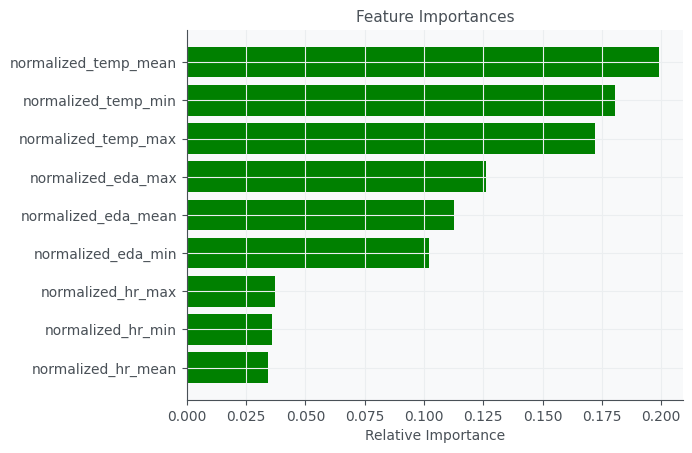

In [56]:
# -- feature importance graph
importances = clf.feature_importances_
indices = np.argsort(importances)
features = train_set.columns
plt.title('Feature Importances')
j = 9   # top j importance
plt.barh(range(j), importances[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Relative Importance')
plt.show()

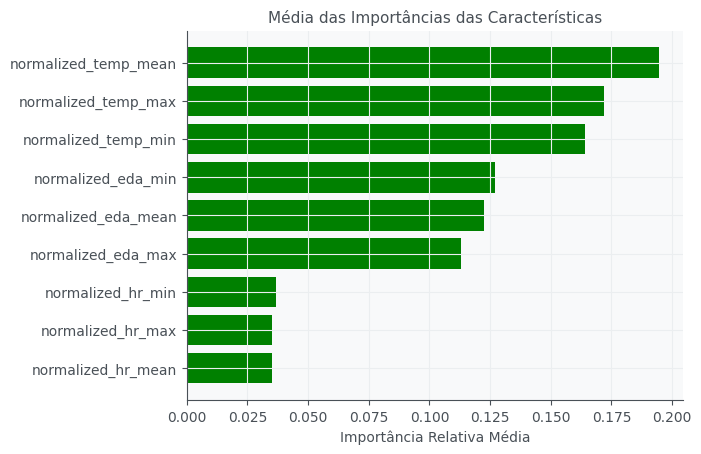

In [57]:
num_execucoes = 100
importancias_medias = np.zeros(X_train.shape[1])  # Lista para armazenar as importâncias médias das características

for _ in range(num_execucoes):
    clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=None) 
    clf.fit(X_train, y_train.ravel()) 
    
    importancias = clf.feature_importances_
    importancias_medias += importancias

importancias_medias /= num_execucoes # Calcular a média das importâncias das características

indices = np.argsort(importancias_medias)
plt.title('Média das Importâncias das Características')
j = 9   # top j importância
plt.barh(range(j), importancias_medias[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Importância Relativa Média')
plt.show()